# Main code of AOI

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from base.node import FKnode, LRnode, FHNnode, HHnode
from base.channel import CHR2
from base.method import difsys, JCB, TCD, DLS, SynFactor, Electrode
from base.plt import Plotter

# Models

In [7]:
############# # Model Instantiation ##############
l = 120                         # media size
difmatrix = difsys(l)           # instantiation of reaction-diffusion systems
conn_matrix, _ = difmatrix()    # connection matrix

############## FHN model ###############
# node = FHNnode(dt = 0.01)     # node instantiation
# FHN_data = np.load(r"init/FHN120.npy")
# v = FHN_data[0]
# w = FHN_data[1]
# vw = [v, w]
# node._initialize(vw)
# D = 0.1                       # diffusion coefficient
# iext = np.full((l*l), 0.15)   # constant current
# JCB_th = 0.5                  # Jacobi threshold
# v_max = 2.                    # Max. potential
# v_min = -2.                   # Min. potential

############### HH model ###############
# node = HHnode(dt = 0.01)      # node instantiation
# HH_data = np.load(r"init/HH120.npy")
# v = HH_data[0]
# m = HH_data[1]
# n = HH_data[2]
# h = HH_data[3]
# vmnh = [v, m, n, h]
# node._initialize(vmnh)
# D = 0.1865                    # diffusion coefficient
# iext = np.full((l*l), 1.5)    # constant current
# JCB_th = 100.                 # Jacobi threshold
# v_max = 40.                   # Max. potential
# v_min = -85.                  # Min. potential

############### FK model ###############
# node = FKnode(dt = 0.01)      # node instantiation
# FK_data = np.load(r"init/FK120.npy")
# v=FK_data[0]
# u=FK_data[1]
# w=FK_data[2]
# vuw = [v, u, w]
# node._initialize(vuw)
# D = 0.15                      # diffusion coefficient
# iext = np.full((l*l), 0.0)    # constant current
# JCB_th = 0.01                 # Jacobi threshold
# v_max = 1.                    # Max. potential
# v_min = 0.                    # Min. potential

############### LR model ###############
node = LRnode(dt = 0.01)        # node instantiation
LR_data = np.load(r"init/LR120.npy")
v = LR_data[0]
m = LR_data[1]
h = LR_data[2]
j = LR_data[3]
d = LR_data[4]
f = LR_data[5]
X = LR_data[6]
Cai = LR_data[7]
init_LR = [v, m, h, j, d, f, X, Cai]
node._initialize(init_LR)
D = 0.25                        # diffusion coefficient
iext = np.full((l*l), 0.0)      # constant current
JCB_th = 100.                   # Jacobi threshold
v_max = 20.                     # Max. potential
v_min = -85.                    # Min. potential

############## CHR2 channel ##############
chr2 = CHR2(node)               # instantiation of ChR2

# Parameters

In [8]:
############# Simulation parameters ############
trans = 0                       # initial length
train_len = 20                  # train length
test_len  = 100                 # test length

t_d = 1000                      # phase sampling interval: Influence the PS location
o_reset = int(2*t_d)            # AOI relocation interval: If not relocating the AOI, set it to infinity

alpha   = 0.00003               # hyperparameter alhpa, modulation AOI amplitude
abla_r  = 100                   # light source radius: > 85 then global illumination
LED_len = 5                     # LEDs size (Len * Len): change it to 1, 5, 10 or you want (common divisor of 120)

# Settings

In [9]:
############### Simulation Settings ##############
sum_len = int((trans + train_len + test_len)/node.dt)   # Total simulation time
mem_data = np.zeros((l*l, sum_len))                     # Membrane potential list
dls_data = np.zeros((l*l, sum_len))                     # Lighting intensity list
opt_data = np.zeros((l*l, sum_len))                     # Light-induced current list

################# Illuminated area ###############
LEDarray = Electrode(l)                                 # Instantiation of LED arrays
LED = LEDarray.array(LED_len)                           # List of nodes within LEDs, one row of nodes per LED
circle = LEDarray.circle(l/2*l+l/2, abla_r)             # List of nodes in illuminated area (center, radius)
local = np.intersect1d(LED[:, 0], circle)               # First node numbers of working LEDs
LED_circle = np.where(np.isin(LED[:, 0], local))[0]     # Rows of the trained nodes
LED_nodes = LED[LED_circle]                             # Nodes in these rows

################## DLS Settings ###################
DLSer = DLS(N = 30, local = local, alpha = alpha, dt = node.dt) # DLS instantiation
Aex = np.random.uniform(-.01/30, .01/30, (l*l, 30))             # Aex initialization
factor = np.ones((l*l, 30))                                     # Factor initialization
gdls = np.full((l*l,), 0.0)                                     # Initial light = 0

############### Phase singularity #################
vtime0 = node.v.reshape(l,l)                # Initial sample V0
# density = TCD(l, v_mean = 0.4)              # Topological charge density (TCD)
Jacobi = JCB(l, JCB_th)                     # Jacobian determinant (JCB)
tra = np.zeros((l, l))                      # PS trajectory diagram

############# Synchronization factor ##############
synF = SynFactor(5000, l*l)                 # steps, number of nodes
synF.reset()

# Simulation

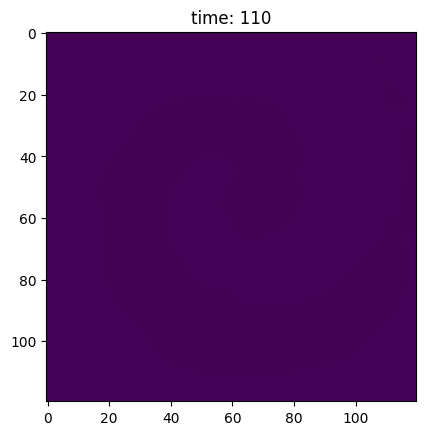

In [10]:
############# Defibrillation simulation #############

plt.ion()                                       # Interaction mode
fig, ax = plt.subplots()

for i in range(sum_len):

    isyn = D * conn_matrix @ node.v             # Synaptic currents
    # iopt = gdls                                 # (1) Direct training of ion currents, electric fields
    # gdls = np.where(gdls < 0.0, 0.0, gdls)      # Simplified light-induced current, light intensity is positive
    # iopt = gdls * (v_max - node.v)              # (2) Depolarization currents
    # iopt = gdls * (v_min - node.v)              # (3) Hyperpolarization currents
    iopt = chr2(gdls)                           # (4) ChR2 currents
    inputs = isyn + iext + iopt                 # Total input currents of the nodes
    node.integral(inputs)                       # Update the node membrane potentials
    mem_data[:,i] = node.v                      # Record the membrane potentials
    opt_data[:,i] = iopt                        # Record the light-induced currents

    if i >= 15000:
        synF(node.v)                            # Iterative synchronization factor

    if i % t_d == 0:                            # Update PS
        vtime1 = node.v.reshape(l, l)           # Update sample V1
        jcb, vtime0 = Jacobi.cal(vtime1, vtime0)  # (1) Calculate JCB
        # tcd, vtime0 = density(vtime1, vtime0)   # (2) Calculate TCD
        if i>t_d:
            tra[np.unravel_index(np.argmax(jcb), jcb.shape)] = 1    # Updated JCB tracks
            # tra[tcd == 1] = 1                 # Updated TCD tracks

        # Instant images
        clear_output(wait=True)     
        ax.clear()     
        ax.imshow(node.v.reshape(l, l), cmap='viridis', vmax=v_max, vmin=v_min) # Displays V snapshots
        ax.set_title(f'time: {int((i+1)*node.dt)}')
        display(fig)                
        plt.pause(0.1)              

    if trans/node.dt < i < (trans+train_len)/node.dt:               # Training periods
        if i % o_reset == 0:                                        # Reposition AOIs
            Aex = np.random.uniform(-.01/30, .01/30, (l*l, 30))     # Reinitialize Aex
            factor = np.ones((l*l, 30))                             # Reinitialize factor
            abla_o = np.array([np.argmax(jcb)])                     # The AOI center is PS
            # abla_o = np.where(tcd.reshape(l*l) == 1)[0]             # The AOI center is PS
            if abla_o.size != 0:                                    # PS exists
                circle = LEDarray.circle(abla_o[0], abla_r)         # Update AOIs area
                DLSer.local = np.intersect1d(LED[:, 0], circle)     # Number of new trained nodes
                LED_circle = np.where(np.isin(LED[:, 0], local))[0] # Rows of the trained nodes
                LED_nodes = LED[LED_circle]                         # Nodes in these rows
                DLSer.reset()                                       # Reset the Prs matrix
                # chr2.reset()                                       # Reset the ChR2
        else:                                                   # Apply AOIs
            V_train = node.v                                    # Trained membrane potential
            V_train[local] = np.mean(node.v[LED_nodes], 1)      # The first node V = V_mean in LEDs
            DLSer.train(Aex, factor, V_train, self_y=None)      # Training DLS
            gdls = (Aex*factor).sum(1)                          # Update light intensity
            gdls[LED] = gdls[LED[:,0]][:,None]                  # First node light intensity is broadcast to the nodes in LED
            dls_data[:,i] = gdls                                # Record the light intensity
    elif i == (trans + train_len)/node.dt:                      # End of training
        gdls[:] = 0.0                                           # Turn off the lights

# np.save('mem_data.npy', mem_data) # Save the data

# PS tracks

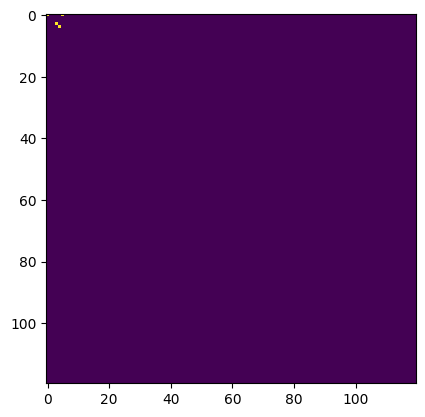

In [11]:
plt.imshow(tra, cmap='viridis')

# Statistics

In [12]:
# Ionic energy
E_data = abs(opt_data * mem_data)
E_ion = sum(sum(E_data))

# optical energy
dls_data[dls_data < 0] = 0
E_opt = sum(sum(dls_data))

# Synchronization factor
R = synF.return_syn()

print("Ionic energy:", E_ion*1e-18,"mJ")    # E_ion = I_opt * V * size * steps = uA/cm^2*mV*1e-4cm^2*1e-5s = result * 1e-15 mJ
print("optical energy:", E_opt*1e-7,"mJ")   # E_opt = P_AOIs * size * steps = mW/mm^2*1e-4cm^2*1e-5s = result * 1e-7 mJ
print("Synchronization factor =", R)        # R tends to 1:synchronous or 0:asynchronous

Required count:5000, Actual count:0
Ionic energy: 5.345575571625009e-09 mJ
optical energy: 0.20619853267337726 mJ
Synchronization factor = 1.0


# Snapshots

In [13]:
# Drawing instantiation
anim = Plotter(mem_data, l, v_min, v_max, node)

max_index: 11159 max_value: 19.59695320108339


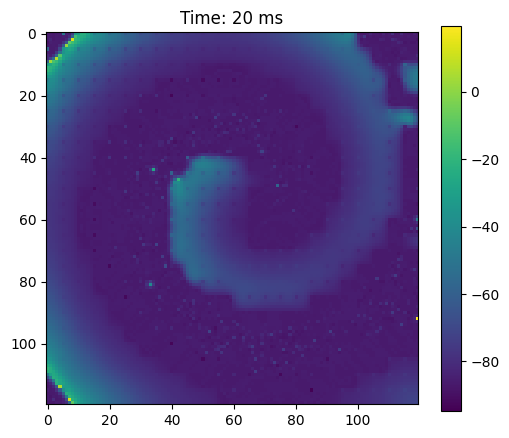

In [14]:
# Snapshot of membrane potentials
frame = 2000
data = mem_data
anim.plot_snapshots(data, frame)

max_index: 9700 max_value: 0.317095486883037


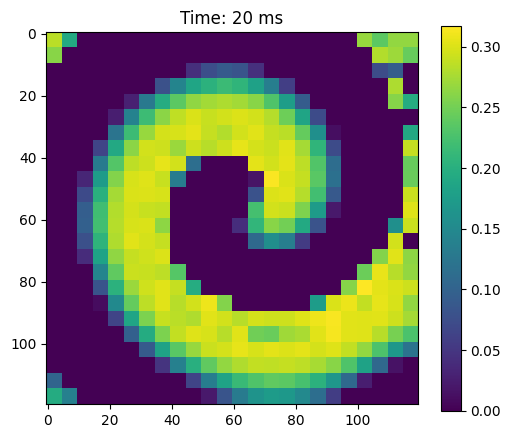

In [15]:
# Snapshot of AOIs
frame = 2000
data = dls_data
anim.plot_snapshots(data, frame)

max_index: 11159 max_value: 0.10871348772923618


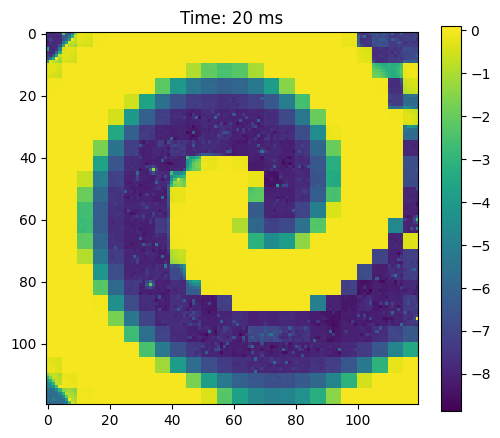

In [16]:
# Snapshot of inght-induce currents
frame = 2000
data = opt_data
anim.plot_snapshots(data, frame)

max_index: 10064 max_value: 790.6094414474436


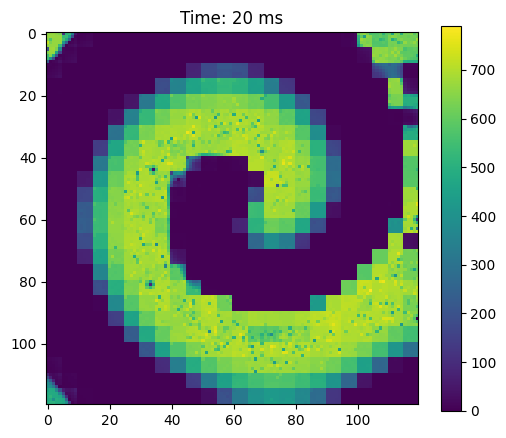

In [17]:
# Snapshot of ionic energy
frame = 2000
data = E_data
anim.plot_snapshots(data, frame)

# Movie

GIF saved as ChR2_LR.gif


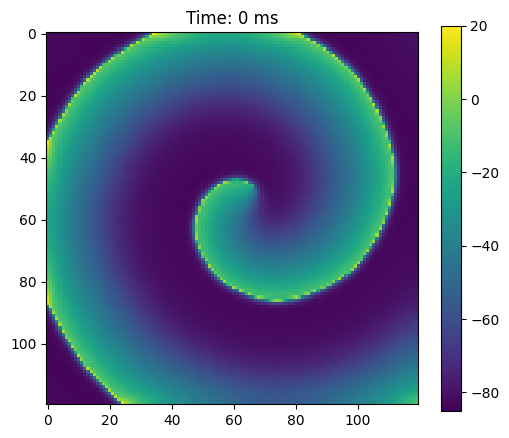

In [18]:
# Draw the gif
anim.create_animation(frames=range(0, mem_data.shape[1], 100), interval=100, output_file='ChR2.gif')